**Анализ данных о покупках** 

Нужно выполнить предварительную обработку данных, сделать разведочный анализ данных EDA, затем проверить гипотезу о данных, выполнить кластеризацию по товарам, определить важные признаки, построить рекомендательную систему. Метод для составления рекомендаций выбрать самостоятельно.

Файл с датасетом - dataset.csv

Датасет - информация о покупках клиентов:

**Дата** - время покупки

**Транзакция** - уникальный номер покупки

**Клиент** - уникальный номер клиента

**Товар** - уникальный номер товара

**Количество** - количество купленных товаров

**Сумма** - цена покупки этого товара

### 1. Импорт библиотек

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from scipy.stats import spearmanr
from scipy.stats import ttest_ind

from sklearn.cluster import KMeans 
from sklearn.feature_selection import SelectKBest,chi2,RFE
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors 

%matplotlib inline


### 2. Загрузка данных

In [2]:
df = pd.read_csv('dataset.csv', delimiter = ';',parse_dates=['Дата'])
df.head()


,Дата,Транзакция,Клиент,Товар,Количество,Сумма
0,2020-03-05 21:43:00,954,1,2874.0,1.0,8150.0
1,2020-11-20 20:46:00,13796,1,3586.0,1.0,3930.0
2,2020-08-12 16:28:00,14431,1,4942.0,1.0,2860.0
3,2020-03-05 21:15:00,951,2,2812.0,1.0,4895.0
4,2020-05-20 16:46:00,3352,2,5025.0,1.0,840.0


### 3. Очистка данных

**Преобразование данных, обработка пропусков, удаление дубликатов**

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48303 entries, 0 to 48302
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Дата        48303 non-null  datetime64[ns]
 1   Транзакция  48303 non-null  int64         
 2   Клиент      48303 non-null  int64         
 3   Товар       48273 non-null  float64       
 4   Количество  48303 non-null  float64       
 5   Сумма       48303 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(2)
memory usage: 2.2 MB


In [4]:
# Проверим количество незаполненных ячеек в исходном датасете
df.isnull().sum()

Дата           0
Транзакция     0
Клиент         0
Товар         30
Количество     0
Сумма          0
dtype: int64

In [5]:
# Уберем записи, в которых отсутствует информация о Товаре
df = df[df['Товар'].isnull() == False]
df.isnull().sum()

Дата          0
Транзакция    0
Клиент        0
Товар         0
Количество    0
Сумма         0
dtype: int64

In [6]:
#Тип данных в колонках 'Товар' и 'Количество' определился как float, хотя эти тип этих
#данных фактически int. Поэтому переназначим тип данных для этих колонок
df[['Товар','Количество']] = df[['Товар','Количество']].astype(int)
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 48273 entries, 0 to 48302
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Дата        48273 non-null  datetime64[ns]
 1   Транзакция  48273 non-null  int64         
 2   Клиент      48273 non-null  int64         
 3   Товар       48273 non-null  int32         
 4   Количество  48273 non-null  int32         
 5   Сумма       48273 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int32(2), int64(2)
memory usage: 2.2 MB


In [7]:
# Удаляем дубликаты данных
df = df.drop_duplicates()
df.shape

(47146, 6)

После удаления неполных записей и повторяющихся записей в датасете осталось 47 146 записей
(уменьшилось на 1 257 записей)

### 4. EDA 
 
**Описательная статистика, поиск взаимосвязей**

In [8]:
# Оценим общие показатели количества клиентов и количества товара в представленный период покупок 
df['День'] = df['Дата'].apply(lambda x: x.date())
Last_day = df['День'].max()
First_day = df['День'].min()
All_days = df['День'].nunique()
print(f"Исходные данные охватывают период с {First_day} по {Last_day} (всего {All_days} дней покупок)")
clients = df['Клиент'].nunique()
tovari = df['Товар'].nunique()
print(f"Всего уникальных клиентов - {clients}\nУникальных товаров - {tovari}")
all_tovari = df['Количество'].sum()
print(f"Всего приобретенно {all_tovari} единиц товара ( в среднем {all_tovari/All_days:.5} единиц товара в день)")


Исходные данные охватывают период с 2020-01-05 по 2021-12-07 (всего 466 дней покупок)
Всего уникальных клиентов - 10989
Уникальных товаров - 5293
Всего приобретенно 47146 единиц товара ( в среднем 101.17 единиц товара в день)


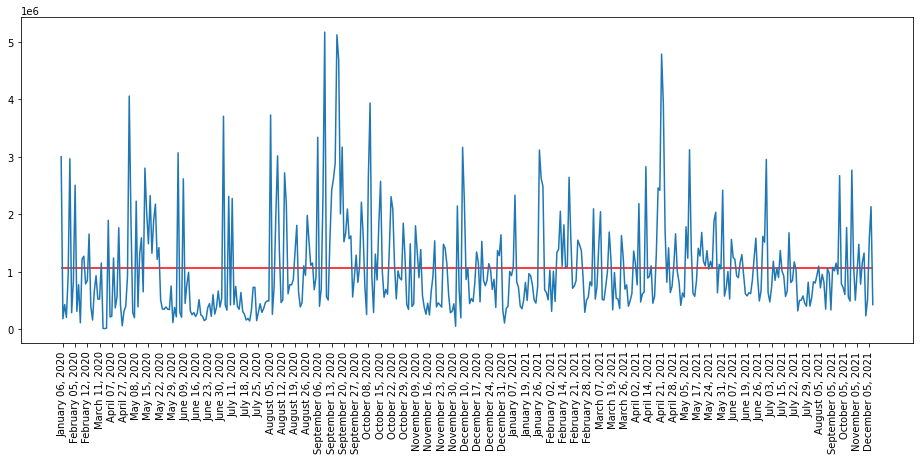

In [9]:
# Строим график сумм покупок за день

s = pd.DataFrame(df.groupby('День').aggregate({'Сумма':"sum"}))
s.reset_index(inplace = True)
s['День_str'] = s['День'].apply(lambda x: x.strftime("%B %d, %Y"))
plt.figure(figsize=(16,6))
plt.plot(s['День_str'], s['Сумма'], )
plt.xticks(np.arange(1,len(s['День_str'])+1, 7),rotation = 90)
x_min = s['День_str'][0]
x_max = s['День_str'][465]
plt.hlines(s['Сумма'].mean(), x_min, x_max, color = 'r')
plt.show()


In [10]:
# Для возможного дальнейшего анализа определим дни недели покупок
df['ДниНедели'] = df['Дата'].dt.weekday.replace({6:'Воскресенье', 0:'Понедельник', 1: 'Вторник'\
                                        ,2: 'Среда', 3: 'Четверг', 4: 'Пятница', 5:'Суббота'})
df.head()

,Дата,Транзакция,Клиент,Товар,Количество,Сумма,День,ДниНедели
0,2020-03-05 21:43:00,954,1,2874,1,8150.0,2020-03-05,Четверг
1,2020-11-20 20:46:00,13796,1,3586,1,3930.0,2020-11-20,Пятница
2,2020-08-12 16:28:00,14431,1,4942,1,2860.0,2020-08-12,Среда
3,2020-03-05 21:15:00,951,2,2812,1,4895.0,2020-03-05,Четверг
4,2020-05-20 16:46:00,3352,2,5025,1,840.0,2020-05-20,Среда


In [11]:
# Определяем количество покупок по дням недели
s = pd.DataFrame(df.groupby(['ДниНедели','День']).aggregate({'Транзакция':'count'}))
s.reset_index(inplace = True)


(array([1, 2, 3, 4, 5, 6, 7]),
 [Text(1, 0, 'Воскресенье'),
  Text(2, 0, 'Вторник'),
  Text(3, 0, 'Понедельник'),
  Text(4, 0, 'Пятница'),
  Text(5, 0, 'Среда'),
  Text(6, 0, 'Суббота'),
  Text(7, 0, 'Четверг')])

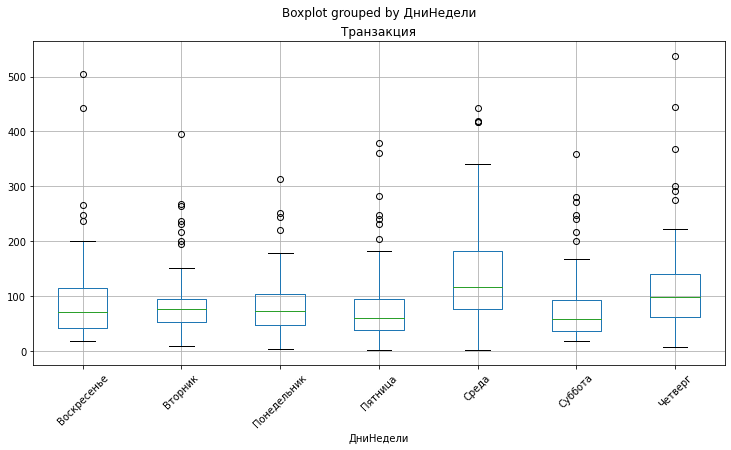

In [12]:
# Строим boxplot и barplot для визуализации интенсивности совершения покупок по дням недели
s.boxplot(column = 'Транзакция', by = 'ДниНедели', figsize=(12,6))
plt.xticks(rotation = 45)

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'Воскресенье'),
  Text(1, 0, 'Вторник'),
  Text(2, 0, 'Понедельник'),
  Text(3, 0, 'Пятница'),
  Text(4, 0, 'Среда'),
  Text(5, 0, 'Суббота'),
  Text(6, 0, 'Четверг')])

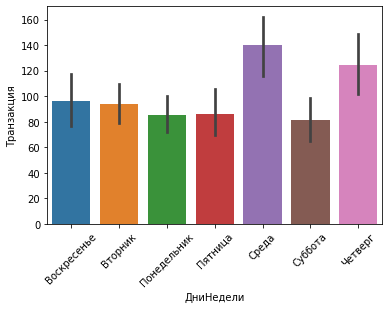

In [13]:
sns.barplot(x = 'ДниНедели', y = 'Транзакция', data = s)
plt.xticks(rotation = 45)

Наибольшее количество покупок совершается в  Среду и Четверг

In [14]:
# Определяем как распределены покупки в течении дня
df['ВремяДня'] = df['Дата'].dt.hour
df.head()

,Дата,Транзакция,Клиент,Товар,Количество,Сумма,День,ДниНедели,ВремяДня
0,2020-03-05 21:43:00,954,1,2874,1,8150.0,2020-03-05,Четверг,21
1,2020-11-20 20:46:00,13796,1,3586,1,3930.0,2020-11-20,Пятница,20
2,2020-08-12 16:28:00,14431,1,4942,1,2860.0,2020-08-12,Среда,16
3,2020-03-05 21:15:00,951,2,2812,1,4895.0,2020-03-05,Четверг,21
4,2020-05-20 16:46:00,3352,2,5025,1,840.0,2020-05-20,Среда,16


In [15]:
s = df.groupby(['ВремяДня','День']).aggregate({'Транзакция':'count'})
s.reset_index(inplace=True)


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(0, 0, '0'),
  Text(1, 0, '10'),
  Text(2, 0, '11'),
  Text(3, 0, '12'),
  Text(4, 0, '13'),
  Text(5, 0, '14'),
  Text(6, 0, '15'),
  Text(7, 0, '16'),
  Text(8, 0, '17'),
  Text(9, 0, '18'),
  Text(10, 0, '19'),
  Text(11, 0, '20'),
  Text(12, 0, '21'),
  Text(13, 0, '22'),
  Text(14, 0, '23')])

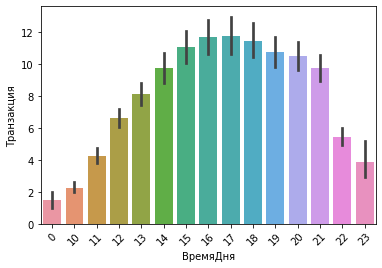

In [16]:
sns.barplot(x = 'ВремяДня', y = 'Транзакция', data = s)
plt.xticks(rotation = 45)

На графие видно что интенсивность покупок 'нормально' соответствует активности покупателей в течении рабочего дня

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(0, 0, '0'),
  Text(1, 0, '10'),
  Text(2, 0, '11'),
  Text(3, 0, '12'),
  Text(4, 0, '13'),
  Text(5, 0, '14'),
  Text(6, 0, '15'),
  Text(7, 0, '16'),
  Text(8, 0, '17'),
  Text(9, 0, '18'),
  Text(10, 0, '19'),
  Text(11, 0, '20'),
  Text(12, 0, '21'),
  Text(13, 0, '22'),
  Text(14, 0, '23')])

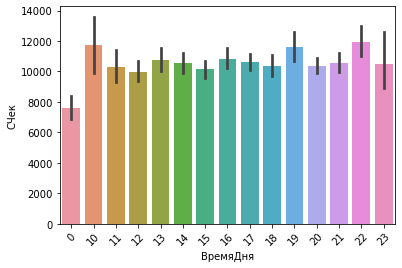

In [17]:
# Определяем как зависит средний чек от времени дня
s = df.groupby(['ВремяДня','День']).aggregate({'Сумма':'sum', 'Транзакция':'count'})
s.reset_index(inplace=True)
s['СЧек'] = s['Сумма']/s['Транзакция']
sns.barplot(x = 'ВремяДня', y = 'СЧек', data = s)
plt.xticks(rotation = 45)

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'Воскресенье'),
  Text(1, 0, 'Вторник'),
  Text(2, 0, 'Понедельник'),
  Text(3, 0, 'Пятница'),
  Text(4, 0, 'Среда'),
  Text(5, 0, 'Суббота'),
  Text(6, 0, 'Четверг')])

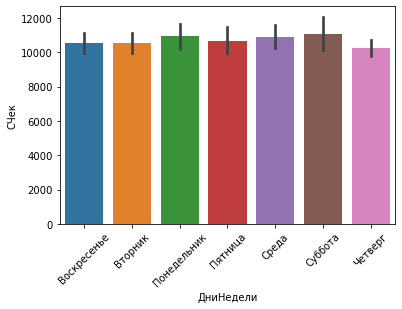

In [18]:
# Определяем зависит ли средний чек от дня недели
s = df.groupby(['ДниНедели','День']).aggregate({'Сумма':'sum', 'Транзакция':'count'})
s.reset_index(inplace=True)
s['СЧек'] = s['Сумма']/s['Транзакция']
sns.barplot(x = 'ДниНедели', y = 'СЧек', data = s)
plt.xticks(rotation = 45)

Вывод - средний чек покупки не сильно зависит от дня недели и несколько увеличивается в начале и в конце рабочего дня

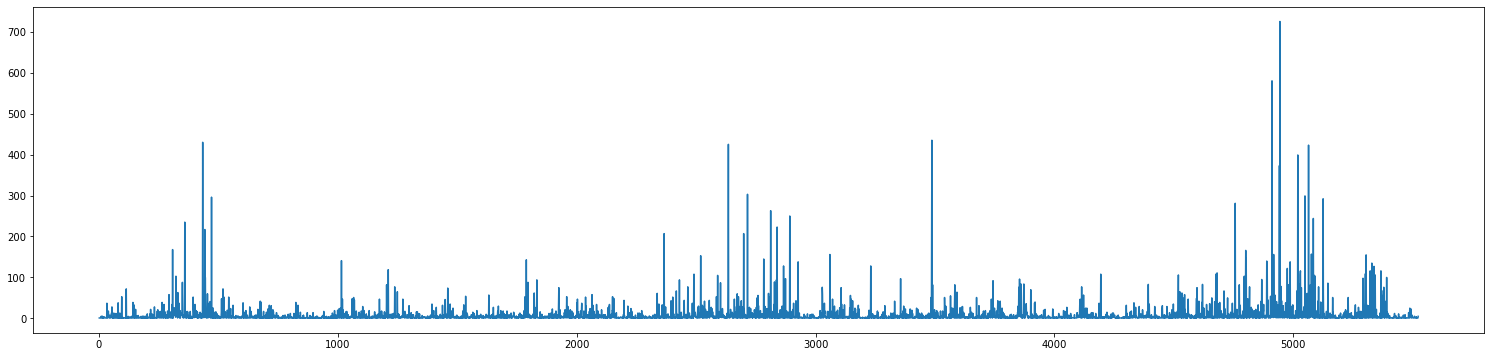

In [19]:
# Оцениваем существуют ли товары, лидеры по продажам
s = df.groupby('Товар').aggregate({'Количество': 'count'})
s.reset_index(inplace = True)
plt.figure(figsize = (26,6))
plt.plot(s['Товар'], s['Количество'])
plt.show()


График распределения частот покупок товаров показывает что существуют наиболее популярные товары

In [20]:
# Определяем min и max количества покупок среди 50  наиболее популярных товаров
max_popular = s['Количество'].max()
ss = tovari
for i in range(1,tovari):
    q = s['Количество'].quantile(i/tovari)
    ss = s[s['Количество'] > q]['Количество'].count()
    if ss < 50:
        break

min_popular = s[s['Количество'] > q]['Количество'].min()


In [21]:
print("Среди 50 самых популярных товаров больше всего покупали:")
print(f"товар {s[s['Количество']== max_popular]['Товар'].values[0]} - {max_popular} раз")
print("Среди 50 самых популярных товаров меньше всего покупали:")
print(f"товар {s[s['Количество']== min_popular]['Товар'].values[0]} - {min_popular} раз")

Среди 50 самых популярных товаров больше всего покупали:
товар 4944 - 725 раз
Среди 50 самых популярных товаров меньше всего покупали:
товар 5302 - 109 раз


**Корреляция**

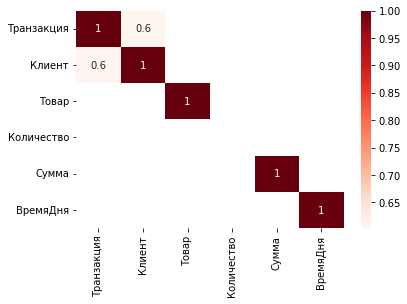

In [22]:
# Для обнаружения возможной корреляции между параметрами возьмем пороговое значение корреляции 0.1
corr = df.corr()
corr_greater = corr[corr >= .1]
corr_greater
sns.heatmap(corr_greater, cmap = "Reds", annot= True);


In [23]:
# оценим коэффициент Спирмена для параметров Клиент и Транзакция
a = df['Клиент']
b = df['Транзакция']
rho_coef, rho_p = spearmanr(a,b)
print(f"коэффициент корреляции Спирмена - {rho_coef:.5f}, p-value - {rho_p:.5f}")

коэффициент корреляции Спирмена - 0.58119, p-value - 0.00000


Полученные значения говорят о наличии существенной корреляции между номером транзакции и 
номером клиента

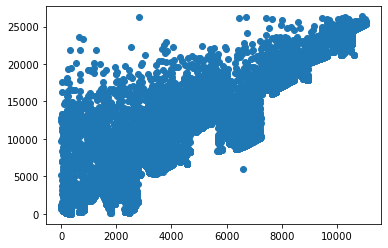

In [24]:
# Строим диаграмму рассеивания для параметров Клиент и Транзакция
s = df.groupby('Клиент').aggregate({'Транзакция': 'count', 'Транзакция':'mean'})
s.reset_index(inplace = True)
plt.scatter(s['Клиент'], s['Транзакция'])
plt.show()

Полученная кореляция и явная тенденция к линейной зависимости на диаграмме рассеивания может 
быть объяснены просто тем, что номера транзакций присваиваются последовательно, номера клиентам
присваиваются последовательно и клиенты совершают покупки определенный период и затем, в основном,
прекращают покупки. Т.е. Транзакции с большими номерами совершают уже, в большей части,
клиенты появившиеся позже

### 5.	Выполнить проверку гипотез о данных

5.1 Зависит ли частота покупок от месяца?

In [25]:
# Словарь месяцев года ( не пригодился)
month = {1:'Январь',2:'Февраль',3:'Март',4:'Апрель',5:'Май',6:'Июнь',7:'Июль',8:'Август',
         9:'Сентябрь',10:'Октябрь',11:'Ноябрь',12:'Декабрь'}

In [26]:
df['Месяц'] = df['Дата'].dt.month
df['ГодМесяц'] = df['Дата'].dt.strftime('%Y-%m')
df.head()

,Дата,Транзакция,Клиент,Товар,Количество,Сумма,День,ДниНедели,ВремяДня,Месяц,ГодМесяц
0,2020-03-05 21:43:00,954,1,2874,1,8150.0,2020-03-05,Четверг,21,3,2020-03
1,2020-11-20 20:46:00,13796,1,3586,1,3930.0,2020-11-20,Пятница,20,11,2020-11
2,2020-08-12 16:28:00,14431,1,4942,1,2860.0,2020-08-12,Среда,16,8,2020-08
3,2020-03-05 21:15:00,951,2,2812,1,4895.0,2020-03-05,Четверг,21,3,2020-03
4,2020-05-20 16:46:00,3352,2,5025,1,840.0,2020-05-20,Среда,16,5,2020-05


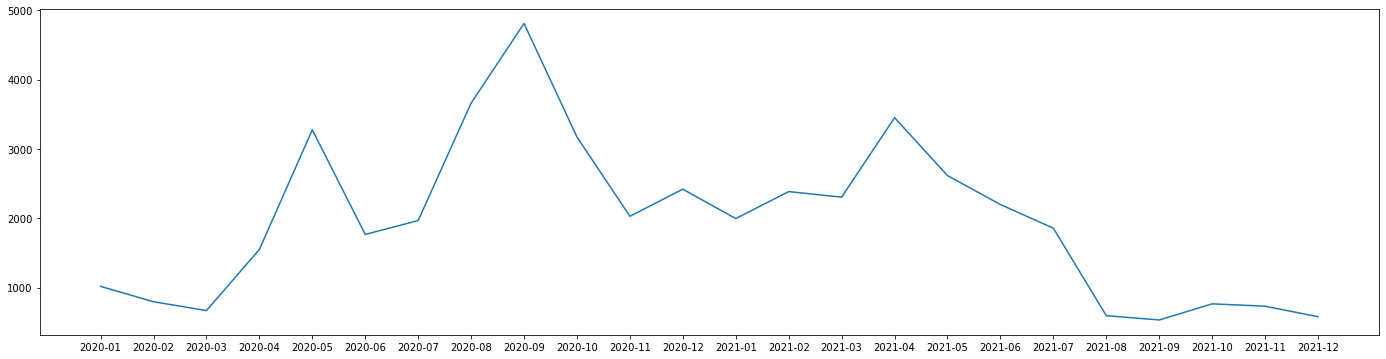

In [27]:
# строим график распределения количества покупок по месяцам

s = df.groupby('ГодМесяц').aggregate({'Транзакция':'count'})
s.reset_index(inplace = True)
plt.figure(figsize = (24,6))
plt.plot(s['ГодМесяц'], s['Транзакция'])
plt.show()

На графике видно что пики продаж наблюдаются в конце апреля- начале мая ежегодно и в сентябре 2020г. Незначительные продажи в начале 2020г. и падение продаж в конце 2021г 
Период относительно 'стабильных' продаж: конец апреля 2020г. - конец июля 2021г

Ранее было определенно что сумма ежедневных покупок примерно равномерна на протяжении периода продаж, 
поэтому ( с учетом того что количество продаж упало) проверяем как изменялся средний чек за день

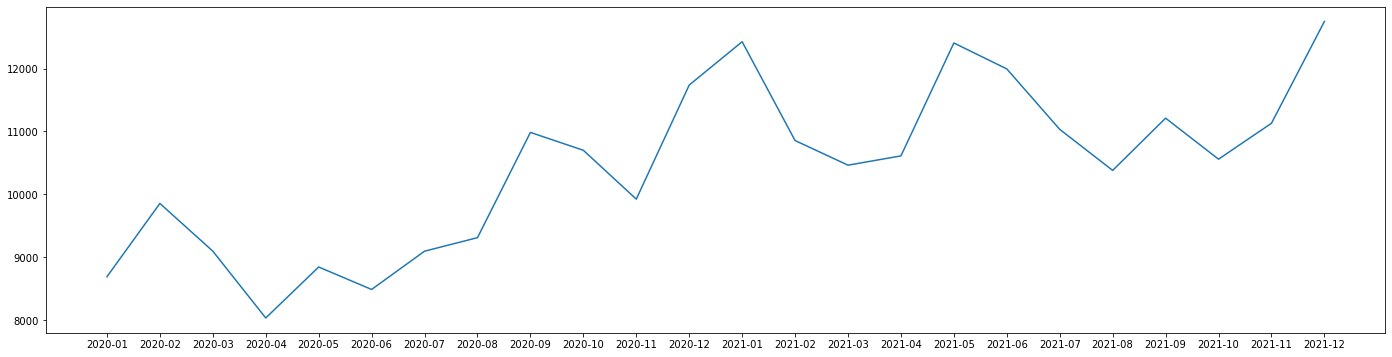

In [28]:
s = df.groupby('ГодМесяц').aggregate({'Сумма':'sum', 'Транзакция':'count'})
s.reset_index(inplace=True)
s['СЧекДень'] = s['Сумма']/s['Транзакция']
plt.figure(figsize = (24,6))
plt.plot(s['ГодМесяц'], s['СЧекДень'])
plt.show()

Видно что средний чек за день увеличивается ( наверное инфляция большая), и при падении объемов транзакций сумма продаж примерно остается на старом уровне

 5.2 Больше лучших клиентов, чем потерянных клиентов?
 
 Т.е. выяснить больше ли клиентов, которые покупали совсем недавно, чаще всего и тратят больше всего, 
 чем клиентов, у которых последняя покупка была давно, и покупали мало и тратили мало.

Определять количество клиентов для группы потерянных худших и новых лучших будем 
для временных отрезков в начале и в конце периода покупок. Временные отрезки будут
задаваться с помощью выделения равных нижнего и верхнего квантилей в диапазоне (0.05 - 0.15)


In [29]:

def old_new(q, df):
    s = df.groupby('Клиент').aggregate({'День':'max', 'Транзакция': 'count', 'Сумма': 'sum'})
    s.reset_index(inplace = True)
    lq = 1-q
    q_day = s['День'].quantile([q, lq])
    q_pokupki = s['Транзакция'].quantile([q, lq])
    q_pokupki
    q_summa = s['Сумма'].quantile([q, lq])
    ss = s[(s['День'] <= q_day[q]) & (s['Транзакция'] <= q_pokupki[q]) & (s['Сумма'] <= q_summa[q])]
    quantity_old = len(ss.index)
    ss = s[(s['День'] > q_day[lq]) & (s['Транзакция'] > q_pokupki[lq]) & (s['Сумма'] > q_summa[lq])]
    quantity_new = len(ss.index)
    return quantity_old, quantity_new
clients_old_new = {}
qvant = np.linspace(0.05, 0.15, 10)
for q in qvant:
    clients_old_new[q] = old_new(q, df)

In [30]:
clients_old_new = pd.DataFrame(clients_old_new, index = ['old', 'new'])
clients_old_new

,0.050000,0.061111,0.072222,0.083333,0.094444,0.105556,0.116667,0.127778,0.138889,0.150000
old,59,79,106,154,187,226,267,316,361,396
new,83,127,158,205,248,282,348,410,442,483


Полученный данные показывают что клиентов, которые покупали совсем недавно, чаще всего и тратят больше всего, больше чем чем клиентов, у которых последняя покупка была давно, и покупали мало и тратили мало.

Для проведения дальнейшего анализа уменьшим размер датафрема. Ограничим набор данных временным интервалом в полгода

### 6. Кластеризация по товарам

In [31]:
# Временной ряд равномерен, весь период 2 года. Полгода - 1/4 от всего периода
df_new = df[df['Дата'] >= df['Дата'].quantile(0.75)]
df_new = df_new.reset_index(drop = True)
df_new['ДниНедели'] = df_new['ДниНедели'].replace({'Воскресенье':6,'Понедельник':0, 'Вторник':1\
                                        ,'Среда':2,'Четверг':3,'Пятница':4, 'Суббота':5})
df_new.head()



,Дата,Транзакция,Клиент,Товар,Количество,Сумма,День,ДниНедели,ВремяДня,Месяц,ГодМесяц
0,2021-05-16 14:38:00,22180,2,1924,1,13200.0,2021-05-16,6,14,5,2021-05
1,2021-05-16 14:38:00,22180,2,1969,1,11500.0,2021-05-16,6,14,5,2021-05
2,2021-05-16 14:38:00,22180,2,2089,1,11500.0,2021-05-16,6,14,5,2021-05
3,2021-08-02 18:19:00,16650,4,833,1,3490.0,2021-08-02,0,18,8,2021-08
4,2021-09-03 14:38:00,18598,4,2437,1,3976.0,2021-09-03,4,14,9,2021-09


Кластеризация по товарам может быть связана только с предпочтениями клиентов. Поэтому проведем кластеризацию по параметрам Клиент, Товар

In [32]:
X = df_new[['Клиент', 'Товар']].copy()
X.head()

,Клиент,Товар
0,2,1924
1,2,1969
2,2,2089
3,4,833
4,4,2437


In [33]:
# Оценивается размер кластеризации ( используется метод локтя)
square_summ = []
x = X.to_numpy()
for i in range(2, 11): # ? использование единичного кластера приводило к внутренней ошибке
                    # алгоритма. Поэтому расчет начиснается с 2-х кластеров
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10,\
                    random_state = 0)
    kmeans.fit(x) #Вычислить кластеризацию k-средних.
    square_summ.append(kmeans.inertia_)


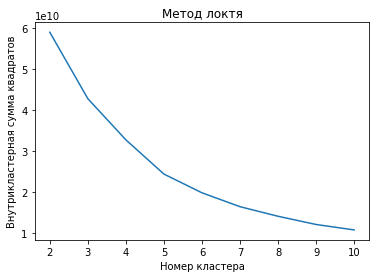

In [34]:
plt.plot(range(2, 11), square_summ)
plt.title('Метод локтя')
plt.xlabel('Номер кластера')
plt.ylabel('Внутрикластерная сумма квадратов') 
plt.show()

In [35]:
# выбираем для расчета количество кластеров: 7
kmeans = KMeans(n_clusters = 7, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
y_kmeans = kmeans.fit(x)
labels1 = kmeans.labels_
centroids1 = kmeans.cluster_centers_
Z = y_kmeans.predict(x)
df_new['Кластер'] = Z
df_new.head()


,Дата,Транзакция,Клиент,Товар,Количество,Сумма,День,ДниНедели,ВремяДня,Месяц,ГодМесяц,Кластер
0,2021-05-16 14:38:00,22180,2,1924,1,13200.0,2021-05-16,6,14,5,2021-05,1
1,2021-05-16 14:38:00,22180,2,1969,1,11500.0,2021-05-16,6,14,5,2021-05,1
2,2021-05-16 14:38:00,22180,2,2089,1,11500.0,2021-05-16,6,14,5,2021-05,1
3,2021-08-02 18:19:00,16650,4,833,1,3490.0,2021-08-02,0,18,8,2021-08,2
4,2021-09-03 14:38:00,18598,4,2437,1,3976.0,2021-09-03,4,14,9,2021-09,1


Text(0, 0.5, 'Товар')

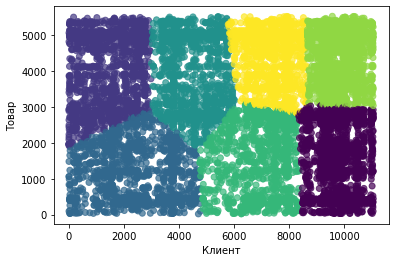

In [36]:
# Строим диаграмму рассеивания для визуализации качества кластеризации данных
# для двух наборров признаков из исходного датасета

# признаки: Клиент, Товар
plt.scatter(x= df_new['Клиент'], y= df_new['Товар'], 
            c = df_new['Кластер'], alpha = 0.7)
plt.xlabel('Клиент')
plt.ylabel('Товар')

Наблюдаются явные предпочтения клиентов относительно товаров

### 7. Важные признаки

Не будем рассматривать в качестве важного параметра Транзакцию, т.к. это несколько искусственный параметр

In [37]:
# Производим выбор существенных признаков для определения Товара
X = df_new[['Транзакция', 'Клиент', 'Количество', 'Сумма',
       'ДниНедели', 'ВремяДня', 'Месяц']]

y = df_new.iloc[:, 3]

bestfeatures = SelectKBest(score_func = chi2, k = 'all')
fit = bestfeatures.fit(X, y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

featureScores = pd.concat([dfcolumns, dfscores], axis = 1)
featureScores.columns = ['Specs', 'Score']  
print(featureScores.nlargest(7, 'Score'))  

        Specs         Score
3       Сумма  1.680923e+08
1      Клиент  5.198990e+06
0  Транзакция  1.692094e+06
4   ДниНедели  3.314327e+03
6       Месяц  2.498453e+03
5    ВремяДня  1.612318e+03
2  Количество  2.058156e-29


Для прогнозирования товара наиболее важными являются признаки: Сумма и Клиент

In [38]:
# Производим выбор существенных признаков для определения Времени дня совершения покупки
X = df_new[['Транзакция', 'Клиент', 'Количество', 'Сумма',
       'ДниНедели', 'Товар', 'Месяц']]

y = df_new.iloc[:, 8]

bestfeatures = SelectKBest(score_func = chi2, k = 'all')
fit = bestfeatures.fit(X, y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

featureScores = pd.concat([dfcolumns, dfscores], axis = 1)
featureScores.columns = ['Specs', 'Score']  
print(featureScores.nlargest(7, 'Score'))  

        Specs         Score
3       Сумма  6.797508e+05
1      Клиент  1.243452e+05
5       Товар  6.868875e+04
0  Транзакция  2.476896e+04
4   ДниНедели  7.264794e+01
6       Месяц  2.469655e+01
2  Количество  1.364804e-29


Для прогнозирования Времени дня совершения покупки важными являются признаки: Сумма, Клиент, Товар

In [39]:
# Производим выбор существенных признаков для определения Дня недели покупки
X = df_new[['Транзакция', 'Клиент', 'Количество', 'Сумма',
       'ВремяДня', 'Товар', 'Месяц']]

y = df_new.iloc[:, 7]

bestfeatures = SelectKBest(score_func = chi2, k = 'all')
fit = bestfeatures.fit(X, y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

featureScores = pd.concat([dfcolumns, dfscores], axis = 1)
featureScores.columns = ['Specs', 'Score']  
print(featureScores.nlargest(7, 'Score'))  

        Specs         Score
3       Сумма  4.357383e+05
0  Транзакция  8.687618e+04
1      Клиент  8.263222e+04
5       Товар  6.080907e+03
6       Месяц  3.603792e+02
4    ВремяДня  3.698923e+01
2  Количество  2.910968e-29


Для прогнозирования Дня недели покупки важными являются признаки: Сумма, Клиент, Товар

### 8.	Рекомендации

При формировании системы рекомендаций на основе количества покупок клиентом отдельных товаров рассмотрим , в том числе, случай когда единичная покупка покупка товара является случайной и требуется рассматривать только повторные покупки

In [ ]:
# Формируется датафрейм с данными о Клиентах, Товарах и Количестве покупок Клиентом Товара
s = df_new.groupby(['Клиент', 'Товар']).aggregate({'Количество':'sum'})
s.reset_index(inplace = True)
print(f"Максимальное количество товара одного типа, купленное Клиентом - {s['Количество'].max()}")
s.head()

In [ ]:
# Определяем как часто  покупки содержали определееное количество товаров
s.groupby('Количество').aggregate({'Количество':'sum'})


Оказалось что о подавляющем большинстве Товары покупаются только один раз!!!

In [ ]:
# Создаем сводную таблицу, где колонки - список всех товаров, строки Клиенты
data_vektor = pd.pivot_table(s, values='Количество', index='Клиент', columns='Товар')
print(data_vektor.shape)
data_vektor.head()

In [ ]:
# Производим замену NaN на 0
data_vektor = data_vektor.fillna(0)
data_vektor.head()

Далее набор функций для обработки исходных данных для реализации коллаборативной
фильтрациb данных на основе пользователей. Используутся модель kNN.
Для проведения расчета необходимо обращаться к функции products_for_recomend

In [ ]:
# Функция recomend принимает на входе матрицу с указанием покупок клиента ( в ячейке указывается
# количество покупок товара данного типа, приобретенного покупателем) - data, количество "ближайших
# соседей" - n_neighbors, Id Клиента - customerId
# возвращает список наиболее "близких" по предпочтениям покупателей

def recomend(data, n_neighbors, customerId):
    knn = NearestNeighbors(n_neighbors=n_neighbors, algorithm= 'brute', metric= 'cosine')
    model_knn = knn.fit(data)

    most_similar_users_to = []
    distance, indice = model_knn.kneighbors(data.iloc[customerId,:].values.reshape(1,-1),\
                                            n_neighbors=n_neighbors)
    for i in range(1, len(distance.flatten())):
        customerId1 = data.index[indice.flatten()[i]]
        most_similar_users_to.append((customerId1, distance.flatten()[i]))

    most_similar_users_to.sort(key=lambda x: x[1], reverse=True)

    return most_similar_users_to[:n_neighbors]   

In [ ]:
# Функция recomend_product на основании списка "близких" по предпочтениям покупателей формирует 
# список рекомендованных товаров, которые купили "близкие" покупатели, но еще не купил
# исследуемый покупатель
def recomend_product(nabor_recomend, data, customerId):
    customers_recomend = [x[0] for x in nabor_recomend]
    products = []
    for j in customers_recomend:
        products.extend([i for i in data.columns if data.loc[j,i] != 0]) 
  
    spisok = [ i for i in set(products) if i not in [i for i in data.columns\
                                                if data.loc[customerId,i] != 0]]
    return sorted(spisok)

In [ ]:
# функция product_for_recomend принимает на входе исходные данных о покупках покупателей
# ( приведенная к векторному виду), количсетво "близких соседей" для построения модели, ID 
# исследуемого пользователя и величину частоты покупок товара для учета ( если возникнет 
# сомнение что одноразовая покупка является случайной и ее не надо учитывать, то можно задать
# большее количество покупок одного товара, product_amount )
# На выходе предлагается список рекомендованных товаров
def products_for_recomend(data_vektor, n_neighbors, customerId, products_amount = 1):
    data_vektor_adj = data_vektor[data_vektor >= products_amount].fillna(0)
    nabor_recomend = recomend(data_vektor_adj, n_neighbors, customerId)
    spisok_products = recomend_product(nabor_recomend, data_vektor, customerId)
    if len(spisok_products) >=1:
        print(f"Список рекомендаций для покупателя {customerId}:")
        print(spisok_products)
    else:
        print(f"Покупателю {customerId} пока нечего предложить")

In [ ]:
#Для расчета принято что единичная покупка не является случайной
products_for_recomend(data_vektor, 10, 13)

In [ ]:
# Для расчета принято что единичная покупка является случайной и не случайной являются 2 покупки
products_for_recomend(data_vektor, 10, 13, 2)

In [ ]:
# Т.к. случаи покупок более 2-х товаров в одной транзакции очень малы, то скорее всего в
# в рекомендациях , при увеличении размера "неслучайной" покупки более 2-х ничего не изменится
products_for_recomend(data_vektor, 10, 13, 3)
products_for_recomend(data_vektor, 10, 13, 4)

## Вывод